# Clusterização de municípios pelos indicadores do IBGE

Este notebook aplica o algoritmo *k-means* para agrupar os municípios por quatro variáveis socioeconômicas:

- IDHM 2010
- PIB per capita 2021
- Densidade demográfica 2010
- Taxa de escolarização (alfabetização) 2010

Esses clusters serão depois utilizados como variáveis *dummy* em modelos de regressão para controlar perfis municipais.


In [57]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator

base = pd.read_csv('../data/dados_unificados_prefeitos_200k.csv')
base.columns = [c.lstrip('﻿') for c in base.columns]

features = base[['idhm_2010', 'pib_per_capita_2021',
                 'densidade_demografica_2010', 'alfabetizacao_2010']]
features = features.dropna()


In [58]:
scaler = StandardScaler()
X = scaler.fit_transform(features)

sse = []
ks = range(1, 10)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
kneedle = KneeLocator(ks, sse, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow or 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X)

features = features.assign(cluster=clusters)
features.head()


,idhm_2010,pib_per_capita_2021,densidade_demografica_2010,alfabetizacao_2010,cluster
0,0.708,18491.217064,133.397997,92.19,2
1,0.689,28184.630102,7.127400,90.88,2
2,0.689,25842.850511,16.509351,89.16,2
3,0.698,23869.415656,12.479830,91.28,2
4,0.628,12322.938529,98.228786,86.29,2


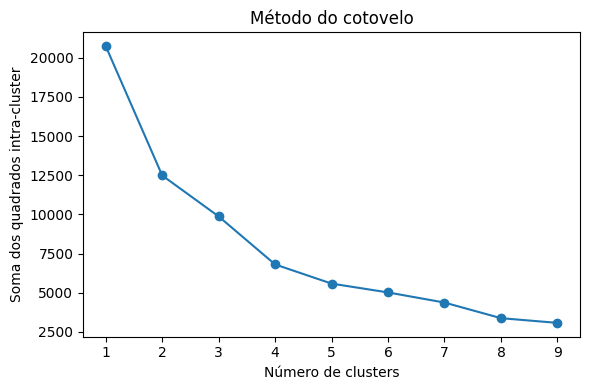

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(list(ks), sse, 'o-')
plt.xlabel('Número de clusters')
plt.ylabel('Soma dos quadrados intra-cluster')
plt.title('Método do cotovelo')
plt.tight_layout()
plt.show()


In [60]:
cluster_dummies = pd.get_dummies(features['cluster'], prefix='cluster')
base_with_clusters = base.join(cluster_dummies)

base_with_clusters.filter(like='cluster_').head()


,cluster_0,cluster_1,cluster_2,cluster_3
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False


Os *clusters* gerados são transformados em variáveis dummy para cada município. O arquivo abaixo pode ser salvo para uso em etapas posteriores do TCC.

In [61]:
base_with_clusters.to_csv('../data/dados_com_clusters.csv', index=False)


# Análise dos clusters

Aqui avaliamos as variáveis socioeconômicas que compõem cada grupo para entender por que os clusters foram formados.

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_stats = features.groupby('cluster').mean().round(2)
cluster_stats

,idhm_2010,pib_per_capita_2021,densidade_demografica_2010,alfabetizacao_2010
cluster,,,,
0,0.59,15516.10,37.07,73.64
1,0.74,31835.59,4085.69,94.85
2,0.71,41081.38,64.08,90.57
3,0.70,244913.15,112.65,90.31


C:\Users\bruno\AppData\Local\Temp\ipykernel_22144\1016996666.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features, x='cluster', y=col, ax=ax, palette='Set2')
C:\Users\bruno\AppData\Local\Temp\ipykernel_22144\1016996666.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features, x='cluster', y=col, ax=ax, palette='Set2')
C:\Users\bruno\AppData\Local\Temp\ipykernel_22144\1016996666.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features, x='cluster', y=col, ax=ax, palette='Set2')
C:\Users\bruno\AppData\Local\Temp\

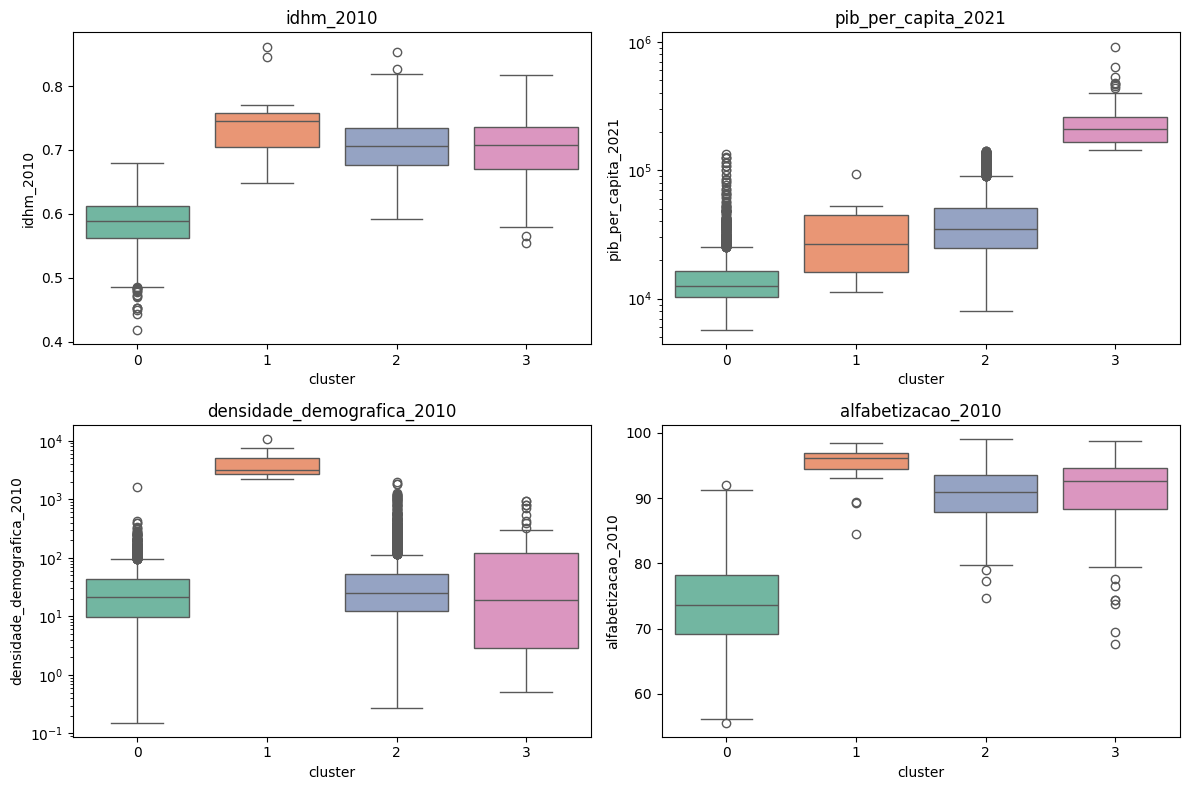

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
cols = ['idhm_2010', 'pib_per_capita_2021', 'densidade_demografica_2010', 'alfabetizacao_2010']
for ax, col in zip(axes.ravel(), cols):
    sns.boxplot(data=features, x='cluster', y=col, ax=ax, palette='Set2')
    if col in ['pib_per_capita_2021', 'densidade_demografica_2010']:
        ax.set_yscale('log')
    ax.set_title(col)
plt.tight_layout()
plt.show()

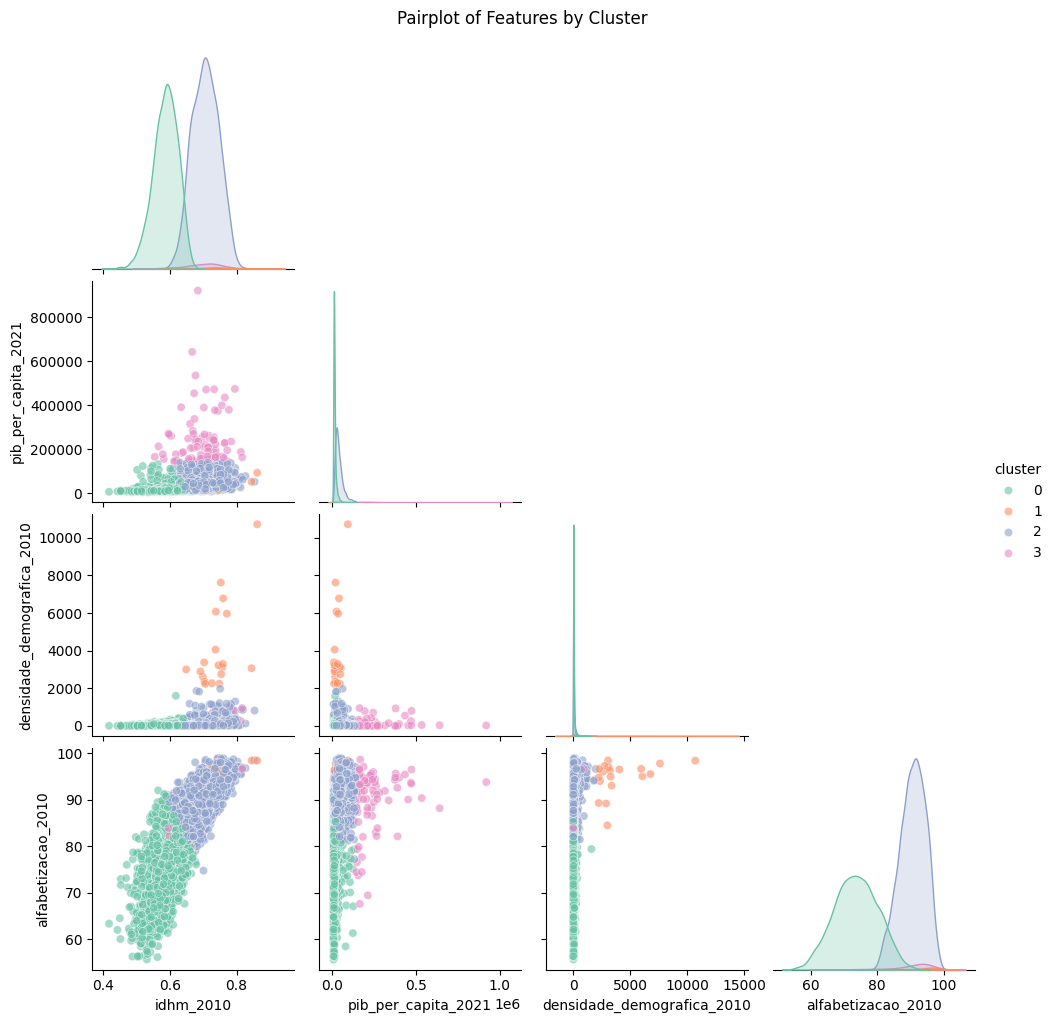

In [64]:
# sns.pairplot(features, vars=cols, hue='cluster', corner=True, plot_kws={'alpha':0.6})

# Plot again, with colors more distinct, and use log scale for better visibility
sns.pairplot(features, vars=cols, hue='cluster', corner=True, palette='Set2', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Features by Cluster', y=1.02)
plt.show()

